# Single-phase flow

In this tutorial we investigate how to solve single-phase flow in **PorePy**. <br>
We consider
* two-point flux approximation
* multi-point flux approximation
* dual virtual element method

**Note**: This tutorial will focus on a 2d domain, however most of the code works for 1d, 2d, and 3d domains.<br>

Let is $\Omega$ a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written in
* dual formulation as:
$$\nabla \cdot \mathbf{u} = f \qquad \mathbf{u} = - K \nabla p$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad \mathbf{u} \cdot \mathbf{n} = u_b$$
* primal formulation as:
$$ - \nabla \cdot K \nabla p = f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Where $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_p$ is the flux at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem. <br><br>

For the example we assume: $\Omega$ as presented below, $\partial \Omega_d = \partial \Omega$, $\partial \Omega_n = \emptyset$, with data: $f = 1$, $K = I$, and $p_b = 0$.

## Import basic modules

Before creating the grid we import some modules.

In [1]:
# Standard modules
import numpy as np
import scipy.sparse as sps

# Module for structured grid and plot with matplotlib
from porepy.grids import structured
from porepy.viz import plot_grid

# Modules for the parameters
from porepy.params import tensor
from porepy.params.data import Parameters
from porepy.params.bc import BoundaryCondition

# Module for geometical manipulations
from porepy.utils import comp_geom

## Creation of the grid

We create first a Cartesian grid.

In [2]:
Nx = Ny = 20                                          
g = structured.CartGrid([Nx, Ny], [2, 2])

We manipulate the grid and then compute its geometrical quantities.

In [3]:
g.nodes[0, :] = g.nodes[0, :] - 1
g.nodes[1, :] = g.nodes[1, :] - 1

def dist(n): return np.dot(comp_geom.rot(np.linalg.norm(n), [0, 0, 1]), n)
g.nodes = np.apply_along_axis(dist, 0, g.nodes)

g.compute_geometry()

We plot the grid using the interface with matplotlib.

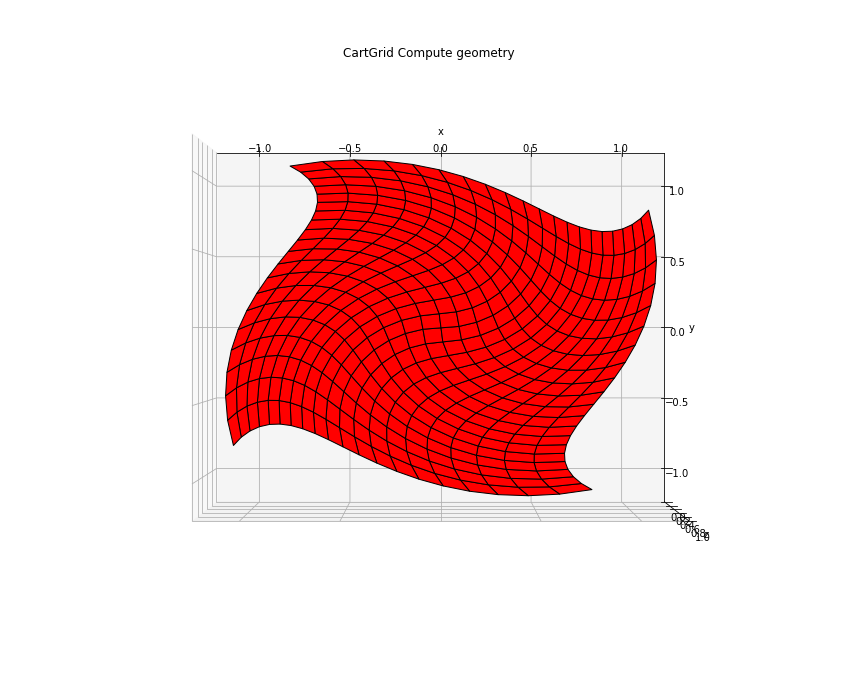

In [4]:
plot_grid.plot_grid(g, figsize=(15, 12))

# Define the problem data

We declare the permeability matrix $K$, the scalar source term $f$, and the boundary conditions

In [5]:
# Permeability
perm = tensor.SecondOrder(g.dim, np.ones(g.num_cells))                     

# Unitary scalar source already integrated in each cell
f = g.cell_volumes

# Boundary conditions
b_faces = g.get_boundary_faces()
bc = BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
bc_val = np.zeros(g.num_faces)

Once all the data are created we group them in a dictionary, where the keyword `"flow"` represent the physical process considered.

In [6]:
param = Parameters(g)
param.set_tensor("flow", perm)
param.set_bc("flow", bc)
param.set_bc_val("flow", bc_val)
param.set_source("flow", f)
data = {'param': param}

## Problem solution

In this section we present all the approaches to solve the problem.<br>
**Note**: The problem data are not stored in the solver class.

### Two-point flux approximation

The two-point flux approximation solves the single-phase flow problem in the primal formulation. The pressure is directly computed.

In [7]:
from porepy.numerics.fv import tpfa, source

solver_flow = tpfa.Tpfa("flow")
A, b_flow = solver_flow.matrix_rhs(g, data)

solver_rhs = source.Integral("flow")
_, b_rhs = solver_rhs.matrix_rhs(g, data)

p = sps.linalg.spsolve(A, b_flow+b_rhs) 

To represent the solution.

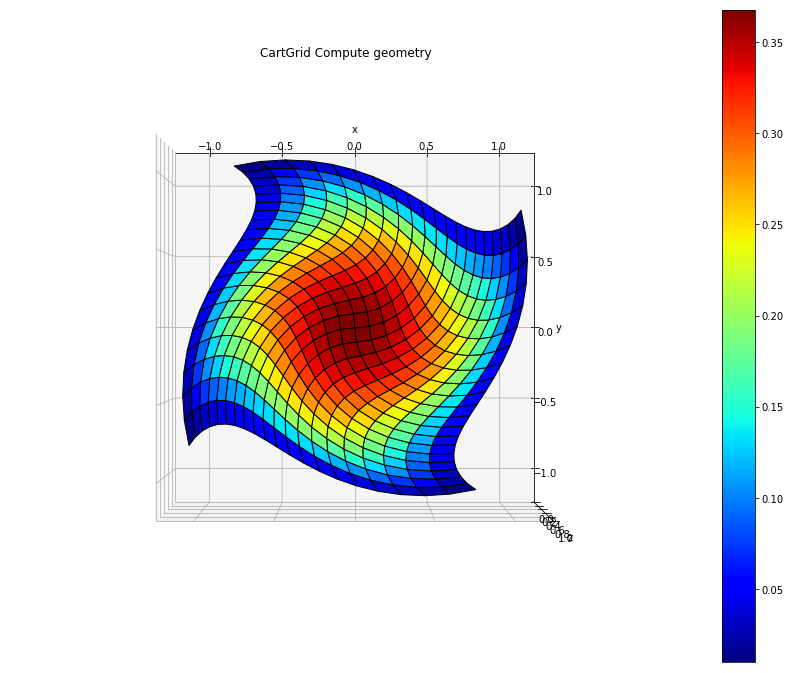

In [8]:
plot_grid.plot_grid(g, p, figsize=(15, 12))

Consistency check:

In [9]:
assert np.isclose(np.sum(p), 76.019359625426816)

### Multi-point flux approximation 

The multi-point flux approximation solves the single-phase flow problem in the primal formulation. The pressure is directly computed.

In [10]:
from porepy.numerics.fv import mpfa

solver_flow = mpfa.Mpfa("flow")
A, b_flow = solver_flow.matrix_rhs(g, data)

solver_rhs = source.Integral("flow")
_, b_rhs = solver_rhs.matrix_rhs(g, data)

p = sps.linalg.spsolve(A, b_flow+b_rhs)

To represent the solution.

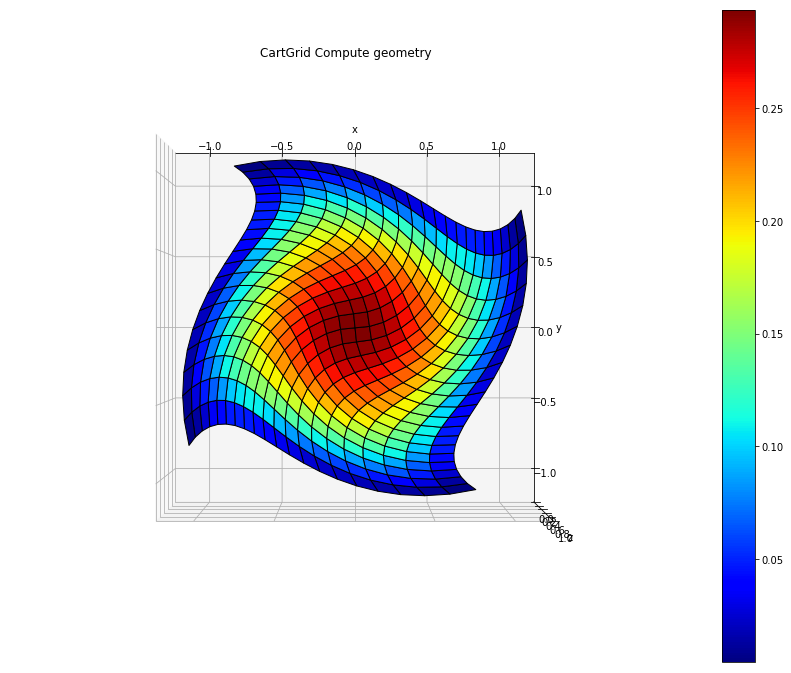

In [11]:
plot_grid.plot_grid(g, p, figsize=(15, 12))

Consistency check:

In [12]:
assert np.isclose(np.sum(p), 56.400386158353612)

### Dual virtual element method

The dual virtual element method solves the single-phase flow problem in the dual formulation. The pressure and the normal flux to each face are directly computed.

In [13]:
from porepy.numerics.vem import vem_dual, vem_source

solver_flow = vem_dual.DualVEM("flow")
A, b_flow = solver_flow.matrix_rhs(g, data)

solver_rhs = vem_source.Integral("flow")
_, b_rhs = solver_rhs.matrix_rhs(g, data)

up = sps.linalg.spsolve(A, b_flow+b_rhs)                                              

# Extract the normal flux and pressure from the solution
u = solver_flow.extract_u(g, up)
p = solver_flow.extract_p(g, up) 

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = solver_flow.project_u(g, u, data)

To represent the solution: pressure and velocity.

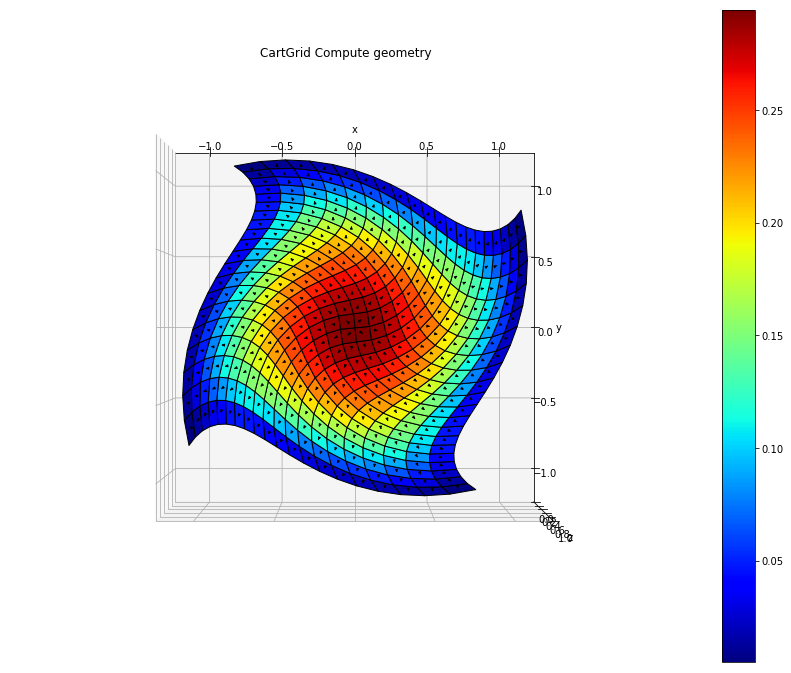

In [14]:
plot_grid.plot_grid(g, p, P0u, figsize=(15, 12))

Consistency check:

In [15]:
assert np.isclose(np.sum(p), 56.939552128161012)
assert np.isclose(np.sum(u), 0)
assert np.isclose(np.sum(P0u), 0)